Exploring the dataset with https://www.kaggle.com/snapcrack/all-the-news
https://www.kaggle.com/miguelniblock/predict-the-author-unsupervised-nlp-lsa-and-bow

In [2]:
# General-purpose Libraries
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")

spacy.prefer_gpu()

False

In [2]:
# Read data into a DataFrame
data = pd.read_csv('all-the-news-2-1.csv')

In [3]:
data.head(3)

,Unnamed: 0,Unnamed: 0.1,date,year,month,day,author,title,article,url,section,publication
0,0,0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of li...,"This post is part of Polyarchy, an independent...",https://www.vox.com/polyarchy/2016/12/9/138983...,NaN,Vox
1,1,1,2016-10-07 21:26:46,2016,10.0,7,Scott Davis,Colts GM Ryan Grigson says Andrew Luck's contr...,The Indianapolis Colts made Andrew Luck the h...,https://www.businessinsider.com/colts-gm-ryan-...,NaN,Business Insider
2,2,2,2018-01-26 00:00:00,2018,1.0,26,NaN,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",https://www.reuters.com/article/us-davos-meeti...,Davos,Reuters


In [4]:
data.info(null_counts =True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688879 entries, 0 to 2688878
Data columns (total 12 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Unnamed: 0    2688879 non-null  int64  
 1   Unnamed: 0.1  2688879 non-null  object 
 2   date          2688878 non-null  object 
 3   year          2688879 non-null  object 
 4   month         2688878 non-null  float64
 5   day           2688879 non-null  object 
 6   author        1667777 non-null  object 
 7   title         2688841 non-null  object 
 8   article       2584165 non-null  object 
 9   url           2676301 non-null  object 
 10  section       1776605 non-null  object 
 11  publication   2676301 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 246.2+ MB


In [5]:
lengths = []
for article in data.article:
    try:
        lengths.append(len(article))
    except:
        pass
print(len(lengths))

2584165


Statistical Summary of Article Lengths
count    2.584165e+06
mean     3.120996e+03
std      3.375865e+03
min      1.000000e+00
25%      1.154000e+03
50%      2.336000e+03
75%      4.058000e+03
max      2.247880e+05
dtype: float64


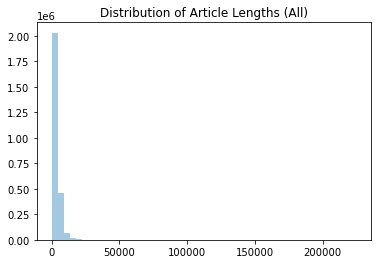

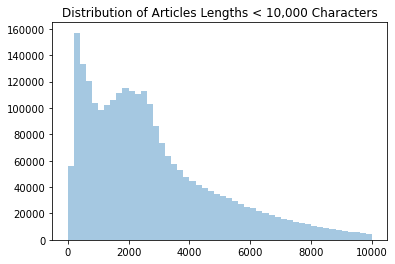

In [6]:
# lengths = pd.Series([len(x) for x in data.article])
lengths = pd.Series(lengths)
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

In [7]:
# authors w/ 100ish articles
print(data.author.value_counts()[data.author.value_counts()>100][-10:])

Rhea Mahbubani         101
Anna Goldfarb          101
Michael Flaherty       101
Stephen Holden         101
Francesca Capossela    101
Vindu Goel             101
David Schwartz         101
Ahmed Aboulenein       101
Jennie Neufeld         101
Dionne Searcey         101
Name: author, dtype: int64


In [8]:
# Df for authors
# incl auth names w/ article titles.

names = data.author.value_counts()[data.author.value_counts()>100][-10:].index.tolist()

In [9]:
# df for artilces of all chosen authors
authors_data = pd.DataFrame()
for name in names:
    # select author's data
    articles = data[data.author==name][:100][['title','article','author']]
    # append to DF
    authors_data = authors_data.append(articles)

In [10]:
authors_data = authors_data.reset_index().drop('index',1)

In [11]:
authors_data.head()

,title,article,author
0,Osama bin Laden was able to hide in Pakistan b...,Osama bin Laden was able to find refuge in Pak...,Rhea Mahbubani
1,Imran Khan calls a potential US-Iran war a 'di...,Pakistan&aposs Prime Minister Imran Khan belie...,Rhea Mahbubani
2,Pakistan's Prime Minister Imran Khan accuses P...,Speaking to reporters at the World Economic Fo...,Rhea Mahbubani
3,Imran Khan: Pakistan won't criticize China on ...,Pakistan&aposs Prime Minister Imran Khan has b...,Rhea Mahbubani
4,Flyers mascot Gritty investigated over claim h...,"Gritty, the Philadelphia Flyers&apos irascible...",Rhea Mahbubani


In [12]:
# look for dups
print('Num of articles: ', authors_data.shape[0])
print('Unique articles: ', len(np.unique(authors_data.index)))

# num authors
print("Unique authors: ", len(np.unique(authors_data.author)))
print('')
print('Articles by author:\n')

# Articles counts by author
print(authors_data.author.value_counts())

Num of articles:  1000
Unique articles:  1000
Unique authors:  10

Articles by author:

Rhea Mahbubani         100
Stephen Holden         100
Anna Goldfarb          100
Francesca Capossela    100
Michael Flaherty       100
Vindu Goel             100
David Schwartz         100
Jennie Neufeld         100
Dionne Searcey         100
Ahmed Aboulenein       100
Name: author, dtype: int64


In [13]:
lengths = pd.Series([len(x) for x in authors_data.article])

Statistical summary of Article Lengths
count     1000.000000
mean      3682.468000
std       2609.662256
min         76.000000
25%       2074.000000
50%       2690.000000
75%       4764.000000
max      35808.000000
dtype: float64


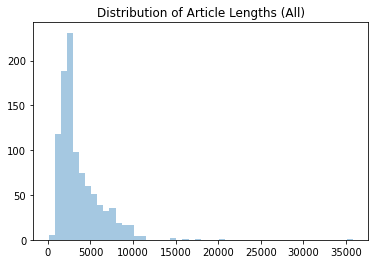

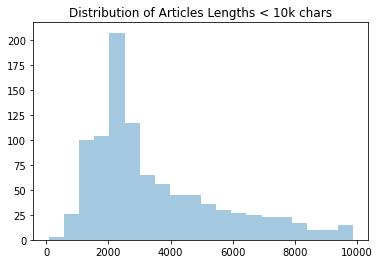

In [14]:
print('Statistical summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths, kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000], kde=False)
plt.title('Distribution of Articles Lengths < 10k chars')
plt.show()

In [18]:
# bag of words of all authors combined. 

# common bow of 1000 words from each author corpus. Combine. Remove dups.

t0 = time()

nlp = spacy.load('en')

common_words = []

# store spacy_doc obj for each author
authors_docs = {}

for name in names:
    # corpus is all text by author
    corpus = ""
    # Grab all rows of current author, along 'article'col
    author_content = authors_data.loc[authors_data.author==name, 'article']
    
    # merge all articles in to the author's corpus
    for article in author_content:
        corpus = corpus + article
    # let spacy parse authpr's body of text
    doc = nlp(corpus)
    
    # store doc in dict
    authors_docs[name] = doc
    
    #filter out punctuation and stop words
    lemmas = [token.lemma_ for token in doc 
             if not token.is_punct and not token.is_stop]
    
    # return most common words of that author's corpus
    bow =[item[0] for item in Counter(lemmas).most_common(1000)]
    
    # add them to the list of words by all authors
    for word in bow:
        common_words.append(word)
    
# eliminate dups
common_words = set(common_words)

print('Total num of common words: ', len(common_words))
print("Done in %0.3fs" % (time() -t0))

Total num of common words:  4347
Done in 397.703s


In [19]:
lengths = []
for k, v in authors_docs.items():
    print(k, 'corpus contains', len(v), ' words.')
    lengths.append(len(v))

Rhea Mahbubani corpus contains 91039  words.
Anna Goldfarb corpus contains 98838  words.
Michael Flaherty corpus contains 43182  words.
Stephen Holden corpus contains 48017  words.
Francesca Capossela corpus contains 41145  words.
Vindu Goel corpus contains 108320  words.
David Schwartz corpus contains 44297  words.
Ahmed Aboulenein corpus contains 68191  words.
Jennie Neufeld corpus contains 44306  words.
Dionne Searcey corpus contains 129009  words.


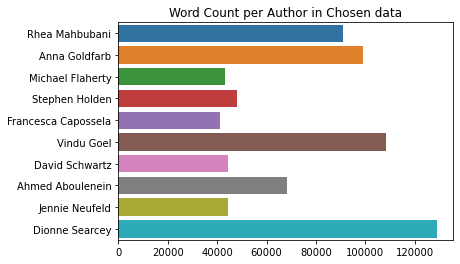

In [20]:
sns.barplot(x=lengths, y=names, orient='h')
plt.title('Word Count per Author in Chosen data')
plt.show()

In [22]:
# bag of words time
# check for lowercase
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Count of all common_words: ', len(common_words))
print('Count of lowercase common_words: ', np.sum([word.islower() for word in common_words]))

# turn all common_words into lowercase
common_words  = [ word.lower() for word in common_words]
print('Count of lowercase common_words (After Conversion): ', np.sum([word.islower() for word in common_words]))

Count of all common_words:  4347
Count of lowercase common_words:  2845
Count of lowercase common_words (After Conversion):  4225


In [24]:
# remove these to avoid conflicts w/ existing features
if 'author' in common_words:
    common_words.remove('author')
    
if 'title' in common_words:
    common_words.remove('title')
    
if 'article' in common_words:
    common_words.remove('article')


In [26]:
# count number of times a common_word appears in eachart
#  3hrs

bow_counts = pd.DataFrame()
for name in names:
    # select X articles of author
    articles = authors_data.loc[authors_data.author==name,:][:100]
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index',1)

# use common_words as cols of temp DF
df = pd.DataFrame(columns=common_words)

# join BOW features w/ authors's content
bow_counts = bow_counts.join(df)

# initialize rows w/ 0s
bow_counts.loc[:, common_words] = 0

# fill df w/ cts of each feature in each article
t0 = time()
for i, article in enumerate(bow_counts.article):
    doc = nlp(article)
    for token in doc:
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i, token.lemma_.lower()] += 1
    # print msg every X articles
    if i% 50 == 0:
        if time() - t0 < 3600: # if less than an hours in seconds
            print("Article ", i, " done after ", (time()-t0)/60, ' minutes')
        else:
            print("Article ", i, " done after ", (time()-t0)/60/60, ' hours')

Article  0  done after  0.010232603549957276  minutes
Article  50  done after  0.5254735827445984  minutes
Article  100  done after  1.1556921601295471  minutes
Article  150  done after  1.6625150044759114  minutes
Article  200  done after  2.356647284825643  minutes
Article  250  done after  2.6540545264879865  minutes
Article  300  done after  2.943559241294861  minutes
Article  350  done after  3.247819976011912  minutes
Article  400  done after  3.5546340624491375  minutes
Article  450  done after  3.8409279704093935  minutes
Article  500  done after  4.094039503733317  minutes
Article  550  done after  4.761409668127696  minutes
Article  600  done after  5.476350939273834  minutes
Article  650  done after  5.780438828468323  minutes
Article  700  done after  6.071402378877004  minutes
Article  750  done after  6.498059837023417  minutes
Article  800  done after  6.971404933929444  minutes
Article  850  done after  7.298340129852295  minutes
Article  900  done after  7.547951467831

In [27]:
bow_counts.head(3)

,title,article,author,etc,difficult,piss,jones,marvell,recent,exposure,...,pandemic,common,outline,setting,impossible,naked,bastian,handle,geometrical,society
0,Osama bin Laden was able to hide in Pakistan b...,Osama bin Laden was able to find refuge in Pak...,Rhea Mahbubani,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Imran Khan calls a potential US-Iran war a 'di...,Pakistan&aposs Prime Minister Imran Khan belie...,Rhea Mahbubani,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Pakistan's Prime Minister Imran Khan accuses P...,Speaking to reporters at the World Economic Fo...,Rhea Mahbubani,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# save it
bow_counts.to_pickle('bow_counts')

NameError: name 'bow_coutns' is not defined

In [29]:
# load it
# bow_counts = pd.read_pickle('bow_counts')

In [31]:
# verify num articles per author
bow_counts.author.value_counts()

Rhea Mahbubani         100
Stephen Holden         100
Anna Goldfarb          100
Francesca Capossela    100
Michael Flaherty       100
Vindu Goel             100
David Schwartz         100
Jennie Neufeld         100
Dionne Searcey         100
Ahmed Aboulenein       100
Name: author, dtype: int64

In [32]:
# clustering from BOW data

# establish outcome & predictors
y = bow_counts['author']
X = bow_counts.drop(['article','author', 'title'],1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.24, 
                                                   random_state = 42,
                                                   stratify=y)

In [47]:
X.head()

,etc,difficult,piss,jones,marvell,recent,exposure,film,tool,msnbc,...,pandemic,common,outline,setting,impossible,naked,bastian,handle,geometrical,society
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# make sure classes are balanced after split
y_test.value_counts()

Dionne Searcey         24
Ahmed Aboulenein       24
Michael Flaherty       24
Vindu Goel             24
Jennie Neufeld         24
Stephen Holden         24
Anna Goldfarb          24
Francesca Capossela    24
Rhea Mahbubani         24
David Schwartz         24
Name: author, dtype: int64

In [35]:
# DF to store results

# for clustering algos, test/train and cross_val will be blank, as clustering requires no test/train split. 

# store results in a DataFrame
metrics = ['Algorithm', 'n_train', 'Features', 'ARI', 'Homogeneity',
          'Silhouette', 'Mutual_Info', 'Vross_val', 'Train_accuracy',
          'Test_accuracy']
performance = pd.DataFrame(columns=metrics)

In [37]:
# string ='iloveyoustu','stulovesmolly'

In [49]:
# fn to quickly eval clustering solns

def evaluate_clust(clust, params, features, i):
    t0 = time()
    print('\n','-'*40, '\n', clust.__class__.__name__, '\n', '-'*40)
    
    # find best params based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clust, params, scoring=score, cv=3).fit(X,y)
    print("Best params: ", search.best_params_)
    y_pred = search.best_estimator_.fit_predict(X)
    print(y_pred)
    
    ari = adjusted_rand_score(y, y_pred)
    performance.loc[i, 'ARI'] = ari
    print(f"Adjusted Rand-Index: {ari:.3f}")
    
    hom = homogeneity_score(y, y_pred)
    performance.loc[i, 'Homogeneity'] = hom
    print(f'Homogeneity Score: {hom:.3f}')
    
    sil = silhouette_score(X, y_pred)
    performance.loc[i, 'Silhouette'] = sil
    print(f"Silhouette Score: {sil:.3f}")
    
    nmi = normalized_mutual_info_score(y, y_pred)
    performance.loc[i, 'Mutual_Info'] = nmi
    print(f"Normalized Mutual-Info Score: {nmi:.3f}")
    
    performance.loc[i, 'n_train'] = len(X)
    performance.loc[i, 'Features'] = features
    performance.loc[i, 'Algorithm'] = clust.__class__.__name__
    
    # print contingency matrix
    crosstab = pd.crosstab(y, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    print(time()-t0, ' seconds.')


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best params:  {'init': 'random', 'n_clusters': 25, 'n_init': 20, 'precompute_distances': False}
[ 6  6  6  6  6 20  7  6  7 20  6  7  7  7  6 10  6 10  6  6 12  7 12 12
  6  6  7  6  6  6  6 12  6  6  7 20  7 12 20  6 20 10 20  6  6 24  7 24
 10 24  6  6  7 24 10 20 12 24 12 20 24 20 20  6 10 12 20 20 20 10 20 20
  6 10 12 20  6  6 20 20 10 20 20  6 20 24 20 20 20 20 20  6 20 20 20 20
 20 20 20 12 15 11 11 10 10 11 10 15 10 10 11 10 10 11 10 11 11 11 11 15
 10 11 10 11 15 11 11 15 10 10 10 11 11 10 11 10 11 11 10 11 11 11 11 10
 23 11 10 11 10 10 11 10 10 11 11 11 10 10 11  7 11 11 11  7 10 11 11  7
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  7 10
 10 10 10 10  7 10 10 10 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22 22
 22 22 22 22 22  7  7 22 22 22 22 22  7 22 22 22 22 22 22 22 22  7  7 22
 22 22 22 22  7 22 22 22 22 22 22 22 22 22 22 22 22 22  7 22  7 22 22 22
 22 22

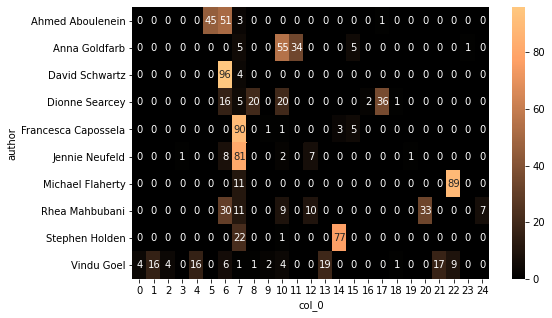

130.4109606742859  seconds.


In [50]:
# kmeans bow
clust = KMeans()
params = {
    'n_clusters': np.arange(10, 30, 5),
    'init': ['k-means++', 'random'],
    'n_init': [10,20],
    'precompute_distances': [True, False]
}
evaluate_clust(clust, params, features='BOW', i=0)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best params:  {}
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 169   0 118
   0   0 163   0   0 164 161   0   0 128   0   0   0   0   0   0   0   0
   0 178 159   0   0 110 152   0   0   0   0 105   0   0   0   0   0 105
 107 108 155 105 112 140   0   0 138   0 111   0 147 132 146 179 127 165
   0 149   0   0   0   0   0   0   0 167 174   0   0   0   0   0 153  89
   0   0 113 176  44   0   0 165 117   0   0   0   0 162   8   0   0   0
   0  10   0 162   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   6
   0   0   0   0   0   0   0   0   0   0   0   0  96   0   0   0   0   0
   0   0  17   0   0   0  37   0 134 100  48 171   0 143   0   0   0   0
   9   0  40   0   0  49   0   0   0   0 173  33  29  14 122  56   0  34
 121  83   0   0   0   0   0   0   0   0   0   0   0   0   0 104   0   0
   0   0 

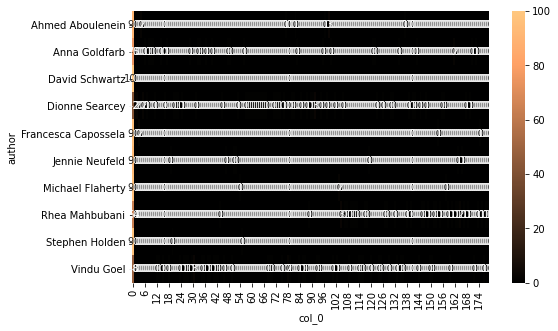

257.45824432373047  seconds.


In [51]:
# mean shift BOW
# declare and fit
clust = MeanShift()

params = {}
evaluate_clust(clust, params, features='BOW', i=1)

In [52]:
# affinity propagation CBOW
# declare and fit the model
clust = AffinityPropagation()

params = {
    'damping': [0.5, 0.7, 0.9],
    'max_iter': [200, 500]
}

evaluate_clust(clust, params, features="BOW", i=2)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best params:  {'damping': 0.5, 'max_iter': 200}
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [53]:
# clearly the above affinity propagation CBOW isn't working right

Adjusted Rand-Index: 0.000
Homogeneity Score: 0.008
Silhouette Score: -0.129
Normalized Mutual-Info Score: 0.016


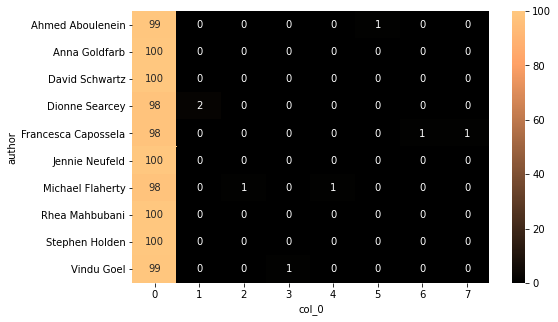

0.9917640686035156  seconds.


In [54]:
# spectral clustering CBOW
# can't use .fit
clust = SpectralClustering()
params={
    'n_clusters': np.arange(10,26, 5),
    # 'eigen_solver': ['arpack', 'lobpcg', None],
    'n_init':[15, 25],
    'assign_labels': ['kmeans', 'discretize']
}

features = 'BOW'

i = 3
t0 = time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i, 'ARI'] = ari
print(f"Adjusted Rand-Index: {ari:.3f}")

hom = homogeneity_score(y, y_pred)
performance.loc[i, 'Homogeneity'] = hom
print(f'Homogeneity Score: {hom:.3f}')

sil = silhouette_score(X, y_pred)
performance.loc[i, 'Silhouette'] = sil
print(f"Silhouette Score: {sil:.3f}")

nmi = normalized_mutual_info_score(y, y_pred)
performance.loc[i, 'Mutual_Info'] = nmi
print(f"Normalized Mutual-Info Score: {nmi:.3f}")

performance.loc[i, 'n_train'] = len(X)
performance.loc[i, 'Features'] = features
performance.loc[i, 'Algorithm'] = clust.__class__.__name__

# print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0, ' seconds.')

In [59]:
performance.iloc[:,:7]
# higher is better, emphasis on mutual_info

,Algorithm,n_train,Features,ARI,Homogeneity,Silhouette,Mutual_Info
0,KMeans,1000,BOW,0.393358,0.636472,-0.0196386,0.620782
1,MeanShift,1000,BOW,0.0135496,0.20909,0.162505,0.25256
2,NaN,NaN,NaN,0,0,NaN,NaN
3,SpectralClustering,1000,BOW,5.07704e-06,0.00801666,-0.129139,0.0156139


In [62]:
# Classification on BOW
# following will 
def score_optimization(clf, params, features, i):
    t0 = time()
    #heading
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)
    # find best params based on sorting of choices
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clf, params, scoring=score, cv=3).fit(X,y)
    
    #extract best estimator
    best = search.best_estimator_
    print("Best params: ", search.best_params_)
    
    # cross-validate on all the data
    cv = cross_val_score(X=X, y=y, estimator=best, cv=5)
    print("\nCross-val scores(All Data): ", cv)
    print("Mean cv score: ", cv.mean())
    performance.loc[i, 'Cross_Val'] = cv.mean()
    
    # get train accuracy
    best = best.fit(X_train, y_train)
    train = best.score(X=X_train, y=y_train)
    performance.loc[i, 'Train_Accuracy'] = train
    print("\nTrain Accuracy Score: ", train)
    
    # get test acc
    test = best.score(X=X_test, y=y_test)
    performance.loc[i, 'Test_Acc'] = test
    print("\nTest Acc Score: ", test)
    
    y_pred = best.predict(X_test)
    
    ari = adjusted_rand_score(y_test, y_pred)
    performance.loc[i, "ARI"] = ari
    print(f"\nAdjusted Rand-Index: {ari:.3f}")
    
    hom = homogeneity_score(y_test, y_pred)
    performance.loc[i, "Homogeneity"] = hom
    print(f"Homogeneity score: {hom:.3f}")
    
    sil = silhouette_score(X_test, y_pred)
    performance.loc[i, 'Silhouette'] = sil
    print(f"Silhouette score: {sil: .3f}")
    
    nmi = normalized_mutual_info_score(y_test, y_pred)
    performance.loc[i, 'Mutual_Info'] = nmi
    print(f"Normed mutual-info score: {nmi:.3f}")
    
    print(classification_report(y_test, y_pred))
    
    conf_matrix = pd.crosstab(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    performance.loc[i,'train'] = len(X_train)
    performance.loc[i, 'Features'] = features
    performance.loc[i, 'Algorithm'] = clf.__class__.__name__
    print(time() - t0, 'seconds')


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best params:  {'C': 0.3, 'penalty': 'l2', 'solver': 'liblinear'}

Cross-val scores(All Data):  [0.99  0.985 0.975 0.975 0.97 ]
Mean cv score:  0.9790000000000001

Train Accuracy Score:  1.0

Test Acc Score:  0.9875

Adjusted Rand-Index: 0.972
Homogeneity score: 0.977
Silhouette score: -0.093
Normed mutual-info score: 0.977
                     precision    recall  f1-score   support

   Ahmed Aboulenein       0.96      1.00      0.98        24
      Anna Goldfarb       0.96      1.00      0.98        24
     David Schwartz       1.00      0.96      0.98        24
     Dionne Searcey       0.96      0.96      0.96        24
Francesca Capossela       1.00      1.00      1.00        24
     Jennie Neufeld       1.00      0.96      0.98        24
   Michael Flaherty       1.00      1.00      1.00        24
     Rhea Mahbubani       1.00      1.00      1.00        24
     Stephen Holde

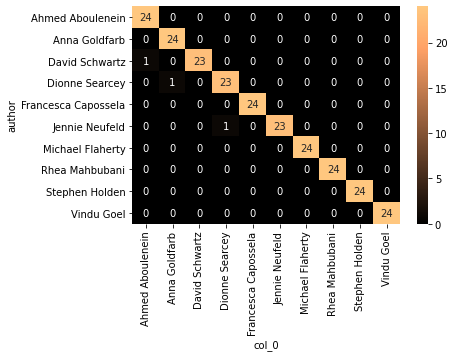

591.5540556907654 seconds


In [63]:
params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'C': [0.3, 0.5, 0.7, 1.0],
        'penalty':['l2']
    },
    {
        'solver': ['liblinear', 'saga'],
        'C': [0.3, 0.5, 0.7, 1.0],
        'penalty':['l1','l2']
    }
]

clf = LogisticRegression(n_jobs =-1)  # use all CPU

score_optimization(clf=clf, params=params, features="BOW", i=4)


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best params:  {'criterion': 'gini'}

Cross-val scores(All Data):  [0.945 0.965 0.98  0.95  0.915]
Mean cv score:  0.951

Train Accuracy Score:  1.0

Test Acc Score:  0.9416666666666667

Adjusted Rand-Index: 0.876
Homogeneity score: 0.907
Silhouette score: -0.095
Normed mutual-info score: 0.907
                     precision    recall  f1-score   support

   Ahmed Aboulenein       1.00      0.96      0.98        24
      Anna Goldfarb       0.91      0.83      0.87        24
     David Schwartz       1.00      1.00      1.00        24
     Dionne Searcey       0.85      0.96      0.90        24
Francesca Capossela       0.96      1.00      0.98        24
     Jennie Neufeld       0.95      0.83      0.89        24
   Michael Flaherty       0.96      0.96      0.96        24
     Rhea Mahbubani       1.00      1.00      1.00        24
     Stephen Holden       0.96      0.96    

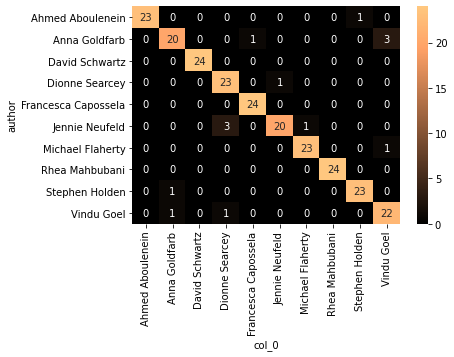

17.44809126853943 seconds


In [64]:
# Random forest CBOW

# params to compare
params = {
    'criterion': ['entropy','gini'],
}

# implement the clf
clf= ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1
)

score_optimization(clf=clf, params=params, features="BOW", i=5)


 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best params:  {'learning_rate': 0.7}

Cross-val scores(All Data):  [0.98  0.99  0.975 0.975 0.94 ]
Mean cv score:  0.9719999999999999

Train Accuracy Score:  1.0

Test Acc Score:  0.9708333333333333

Adjusted Rand-Index: 0.936
Homogeneity score: 0.949
Silhouette score: -0.094
Normed mutual-info score: 0.950
                     precision    recall  f1-score   support

   Ahmed Aboulenein       1.00      0.96      0.98        24
      Anna Goldfarb       0.85      0.96      0.90        24
     David Schwartz       1.00      1.00      1.00        24
     Dionne Searcey       1.00      0.92      0.96        24
Francesca Capossela       0.96      1.00      0.98        24
     Jennie Neufeld       0.95      0.88      0.91        24
   Michael Flaherty       1.00      1.00      1.00        24
     Rhea Mahbubani       1.00      1.00      1.00        24
     Stephen Holden       

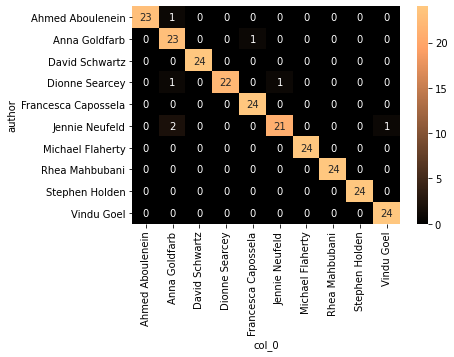

635.1490590572357 seconds


In [65]:
# gradient boosting CBOW
# params to compare
params = {
    'learning_rate': [0.3, 0.5, 0.7, 1]
}

# implement the clf
clf= ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf=clf, params=params, features='BOW', i=6)

In [68]:
# classifiers get higher scores than clustering, despite having been trained on less data
# acc correlates w/ mutual_info

performance.iloc[:7].sort_values('Mutual_Info', ascending=False)[['Algorithm', 'n_train', 'Features', 'Mutual_Info']]

,Algorithm,n_train,Features,Mutual_Info
4,LogisticRegression,NaN,BOW,0.977356
6,GradientBoostingClassifier,NaN,BOW,0.949778
5,RandomForestClassifier,NaN,BOW,0.907092
0,KMeans,1000,BOW,0.620782
1,MeanShift,1000,BOW,0.25256
3,SpectralClustering,1000,BOW,0.0156139
2,NaN,NaN,NaN,NaN


In [3]:
# unsupervised feature generation
# Latent Semantic Analysis

vectorizer = TfidfVectorizer(
    max_df=0.3,  # drop words that occur in more than 30% of docs
    min_df = 8,  # only use words appearing N times
    stop_words='english',
    lowercase=True,  # convert all to lower 
    use_idf=True,  # use inverse doc freq in weighting
    norm=u'l2',  # correction factor so longer paras and shorter paras are treated equally
    smooth_idf = True # adds 1 to all doc freqs, as if an extra doc that used each word once existed. Prevents divide by 0 errors.
)

# pass pandas series to our vectorizer model
counts_tfidf = vectorizer.fit_transform(bow_counts.article)

NameError: name 'bow_counts' is not defined

In [4]:
counts_tfidf

NameError: name 'counts_tfidf' is not defined

In [81]:
svd = TruncatedSVD(920)
svd.fit(counts_tfidf)
svd.explained_variance_ratio_.sum()

0.9980297788093366

In [82]:
lsa = make_pipeline(svd, Normalizer(copy=False))
lsa_data = lsa.fit_transform(counts_tfidf)
lsa_data.shape

(1000, 920)

In [83]:
lsa_data = pd.DataFrame(lsa_data)
lsa_data.head()

,0,1,2,3,4,5,6,7,8,9,...,910,911,912,913,914,915,916,917,918,919
0,0.128444,-0.039135,-0.072209,0.045662,-0.082525,0.047967,0.015413,0.024093,0.005317,0.004423,...,0.049090,0.031633,-0.053587,0.006505,-0.060676,0.015461,-0.029014,-0.015271,-0.055920,0.002064
1,0.126037,-0.039788,-0.063053,0.030537,-0.134958,0.046854,0.029079,0.037696,0.002365,-0.012518,...,-0.045256,-0.033793,0.075644,0.017078,0.124869,-0.026455,0.026735,0.035095,0.082936,-0.000456
2,0.165643,-0.035520,-0.070604,0.035369,-0.143501,0.054175,0.018450,0.027798,0.020646,0.006456,...,0.032551,-0.039661,0.031931,-0.002681,-0.016428,-0.022502,-0.028652,-0.028025,-0.061256,-0.007228
3,0.175605,-0.056085,-0.059583,0.037969,-0.181246,0.064414,0.087187,0.056889,0.015740,-0.022377,...,-0.034610,0.061372,-0.047064,-0.008176,-0.055760,0.040503,0.026335,0.028562,0.036614,-0.001815
4,0.166690,-0.066340,-0.047826,-0.023645,-0.152185,0.096315,-0.019217,0.022342,0.052521,0.019339,...,0.000482,0.001394,-0.000234,0.003146,-0.001978,0.003767,-0.010117,-0.008547,0.001720,0.004184


In [85]:
# clustering on LSA using the BOW content
# first establish X&Y

y = bow_counts['author']
X = lsa_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.24, random_state=42, stratify=y)

In [86]:
y_test.value_counts()

Dionne Searcey         24
Ahmed Aboulenein       24
Michael Flaherty       24
Vindu Goel             24
Jennie Neufeld         24
Stephen Holden         24
Anna Goldfarb          24
Francesca Capossela    24
Rhea Mahbubani         24
David Schwartz         24
Name: author, dtype: int64


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best params:  {'init': 'k-means++', 'n_clusters': 25, 'n_init': 20, 'precompute_distances': False}
[13 13 13 13 13  1 13 13 13  1 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13  0  0  0 12  6 13  1 21  0  1  0  1 13  1  1 21  1  6  1
 21  1 21 13 13  1  0  1  0  1  0  1  1  1  1 21 13 23  1  1  1  0  1  1
  1  1  0  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  0 10 10 10  5  5 10  5 10  5  5 10  5  5 10  5 10 10 10 10 10
  5 10  5 10 10 10 10 10  5  5  5 10 10  5 10  5 10 10  5 10 10 10  5  5
 10 10  5 10  5  5 10  5  5 10 10 10  5  5 10  5 10 10 10  5  5 10 10  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 12  5
  5  5  5  5  5  5  5  5 15 15 15 15 15  4 14 15 15 15  4  4 15  4  4  4
 15  4 15 15 15  4 24 15 14 15 14 15  4  4 15 15 15 15 15 15 15 12  4 15
 15 15  4  4  4  4 15 15 15 15  4 15  4 15 14  4  4  4 24  4  4  4 15 15
 15

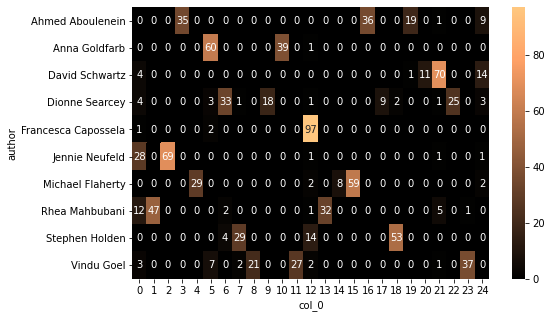

28.671239137649536  seconds.


In [87]:
# kmeans LSA
clust = KMeans()
params = {
    'n_clusters': np.arange(10,30,5),
    'init': ['k-means++', 'random'],
    'n_init': [10, 20],
    'precompute_distances': [True, False]
}
evaluate_clust(clust, params, features='LSA', i=7)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best params:  {'bandwidth': 0.5}
[789 798 596 538 590 341 664 710 569 312 626 776 869 826 480 390 786 495
 785 405 631 719 469 245 637 771 767 345 549 575 567 331 634 754 774 198
 768 463 563 571 239 692 182 739 594 419 711 280 681 460 566 527 658 565
 490 212 391 338 485 263 713 530 229 544 810 291 313 388 319 288 299 205
 295 372 265 404 628 340 294 334 411 382 371 434 292 483 456 238 389 395
 255 324 186 354 129  28  28 211 181 232 641 499 614 639 282 741 526 802
 402 290 700 457 632 591 414 652 663 781 597 745 470 604 462 667 685 442
 846 780 428 249 447 727 683 416 738 517 696 796 471 610 790 424 552 261
 866 729 487 743 508 444 783 357 401 787 676 804 812 377 763 917 735 807
 675 856 330 534 701 581 240 305 757 273 297 454 359 557 545 477 415 436
 301 420 422 476 427 363 686 381 584 511 929 276 413 237 289 192 660 603
 473 373 503  44 645  61 375 310  50  25  51   0  41  42 445 277  

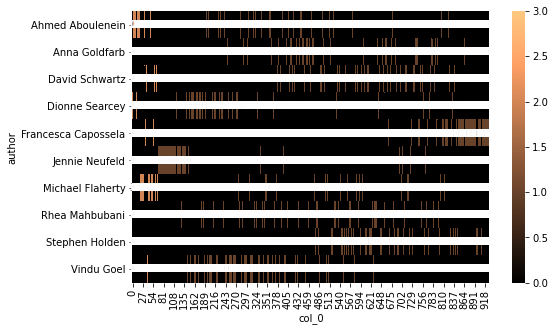

50.90901041030884  seconds.


In [88]:
# mean shift LSA
clust = MeanShift()

params ={
    'bandwidth':[0.5,0.7,0.9]
}

evaluate_clust(clust, params, features='LSA', i=8)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best params:  {'damping': 0.7, 'max_iter': 500}
[  0   0   0   0   2   6   2   2   2   6   3   1   1   1   2   1   1   1
   2   2   2   2   2   2   2   2   3   2   4  10   9   9   4  10   1   6
   3   9   6   4   6   1   6   5   4   5 134   5   4   5   4   4   3   5
   3   6   9   5   9   7   5   8   6 101   1  85   7  11   7  10   7   8
   8   5   9   6  10   8  11   6   8   8   7  11  11   5  11   8   6  11
   8   8  11   8   8  11  11  11   6   9  18  18  15  13  12  18  16  15
  12  12  15  13  65  15  19  14  14  18  15  14  19  15  16  14  15  15
  15  18  24  12  16  15  14  16  14  19  14  15  17  14  15  15  19  16
  18  18  12  14  20  12  15  23  16  14  14  14  18  19  15  60  15  14
  15  24  12  14  15  17  17 147  17  20  12  17  23  20  21  23  21  21
  23  21  24  21  23  23  21  21  21  21  22  12  19  23  24  23  21  49
  23  21  29  25  35  30  36  36  26  27 

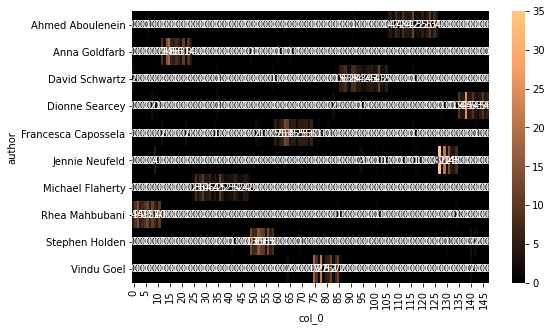

27.08276343345642  seconds.


In [89]:
# affinity prop LSA

clust = AffinityPropagation()
params = {
    'damping': [0.5, 0.7, 0.9],
    'max_iter': [200,500]
}
evaluate_clust(clust, params, features='LSA', i=9)

Adjusted Rand-Index: 0.131
Homogeneity Score: 0.390
Silhouette Score: 0.047
Normed Mutual-Info Score: 0.501


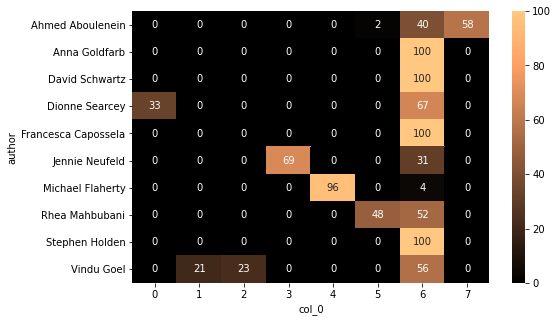

0.6374859809875488 seconds.


In [90]:
# spectral clustering LSA

clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,26,5),
    #'eigen_solver':['arpack','lobpcg',None],
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='LSA'

i=10

t0=time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

sil = silhouette_score(X,y_pred)
performance.loc[i,'Silhouette'] = sil
print("Silhouette Score: %.3f" % sil)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

In [92]:
performance.iloc[:11].sort_values(
    'Mutual_Info', ascending=False
)[['Algorithm', 'n_train', 'Features', 'Mutual_Info', 'Test_accuracy']]

,Algorithm,n_train,Features,Mutual_Info,Test_accuracy
4,LogisticRegression,NaN,BOW,0.977356,NaN
6,GradientBoostingClassifier,NaN,BOW,0.949778,NaN
5,RandomForestClassifier,NaN,BOW,0.907092,NaN
7,KMeans,1000,LSA,0.74063,NaN
0,KMeans,1000,BOW,0.620782,NaN
9,AffinityPropagation,1000,LSA,0.607216,NaN
8,MeanShift,1000,LSA,0.505353,NaN
10,SpectralClustering,1000,LSA,0.500846,NaN
1,MeanShift,1000,BOW,0.25256,NaN
3,SpectralClustering,1000,BOW,0.0156139,NaN



 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best params:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}

Cross-val scores(All Data):  [0.985 0.98  0.965 0.975 0.95 ]
Mean cv score:  0.9709999999999999

Train Accuracy Score:  0.9789473684210527

Test Acc Score:  0.9666666666666667

Adjusted Rand-Index: 0.926
Homogeneity score: 0.939
Silhouette score:  0.048
Normed mutual-info score: 0.940
                     precision    recall  f1-score   support

   Ahmed Aboulenein       0.96      1.00      0.98        24
      Anna Goldfarb       0.89      1.00      0.94        24
     David Schwartz       0.96      0.96      0.96        24
     Dionne Searcey       0.96      0.92      0.94        24
Francesca Capossela       0.96      0.96      0.96        24
     Jennie Neufeld       1.00      0.96      0.98        24
   Michael Flaherty       1.00      1.00      1.00        24
     Rhea Mahbubani       1.00      1.00      1.00        2

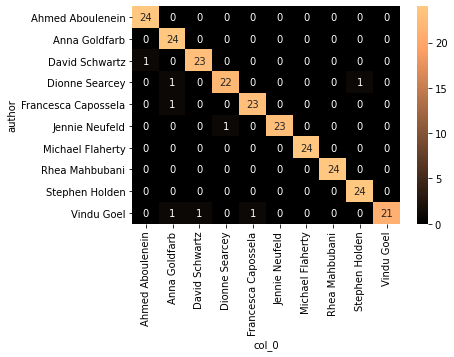

97.86729907989502 seconds


In [93]:
# classification on LSA (Bow Content)
# supervised

params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'C': [0.3, 0.5, 0.7, 1],
        'penalty':['l2']
    }, {
        'solver':['liblinear', 'saga'],
        'C': [0.3, 0.5, 0.7, 1],
        'penalty': ['l1','l2']
    }
]

clf = LogisticRegression(
    n_jobs=-1
)

score_optimization(clf=clf, params=params, features='LSA', i=11)


 ---------------------------------------- 
 RandomForestClassifier 
 ----------------------------------------
Best params:  {'criterion': 'gini'}

Cross-val scores(All Data):  [0.955 0.955 0.95  0.955 0.905]
Mean cv score:  0.944

Train Accuracy Score:  1.0

Test Acc Score:  0.9541666666666667

Adjusted Rand-Index: 0.897
Homogeneity score: 0.919
Silhouette score:  0.048
Normed mutual-info score: 0.919
                     precision    recall  f1-score   support

   Ahmed Aboulenein       0.96      1.00      0.98        24
      Anna Goldfarb       0.82      0.96      0.88        24
     David Schwartz       0.92      0.96      0.94        24
     Dionne Searcey       0.92      0.96      0.94        24
Francesca Capossela       1.00      0.92      0.96        24
     Jennie Neufeld       1.00      0.92      0.96        24
   Michael Flaherty       1.00      1.00      1.00        24
     Rhea Mahbubani       1.00      0.96      0.98        24
     Stephen Holden       1.00      0.96    

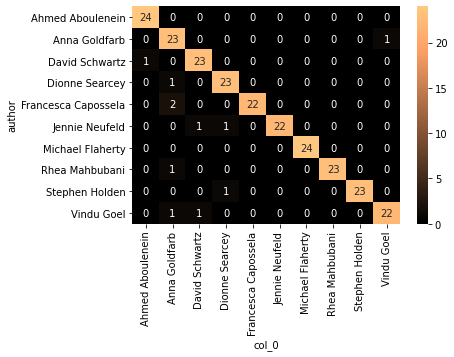

40.96758508682251 seconds


In [94]:
# random forest LSA on BOW data

params = {
    'criterion': ['entropy','gini']
}

# impl clf
clf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_features=None,
    n_jobs=-1
)

score_optimization(clf=clf, params=params, features='LSA', i=12)


 ---------------------------------------- 
 GradientBoostingClassifier 
 ----------------------------------------
Best params:  {'learning_rate': 0.7}

Cross-val scores(All Data):  [0.965 0.96  0.955 0.935 0.93 ]
Mean cv score:  0.9490000000000001

Train Accuracy Score:  1.0

Test Acc Score:  0.9666666666666667

Adjusted Rand-Index: 0.926
Homogeneity score: 0.939
Silhouette score:  0.047
Normed mutual-info score: 0.940
                     precision    recall  f1-score   support

   Ahmed Aboulenein       1.00      1.00      1.00        24
      Anna Goldfarb       0.96      1.00      0.98        24
     David Schwartz       1.00      0.96      0.98        24
     Dionne Searcey       0.85      0.96      0.90        24
Francesca Capossela       1.00      0.96      0.98        24
     Jennie Neufeld       0.96      0.92      0.94        24
   Michael Flaherty       1.00      1.00      1.00        24
     Rhea Mahbubani       1.00      0.96      0.98        24
     Stephen Holden       

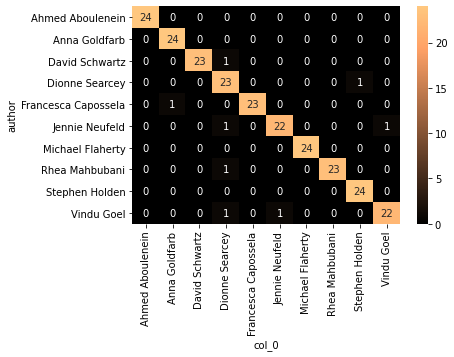

2675.400910139084 seconds


In [95]:
# gradient boosting 
params = {
    'learning_rate': [0.3, 0.5, 0.7, 1]
}

clf = ensemble.GradientBoostingClassifier(
    max_features=None
)

score_optimization(clf, params, features='LSA', i=13)

In [97]:
performance.iloc[:14].sort_values('Mutual_Info', ascending=False)[['Algorithm','n_train', 'Features','Mutual_Info','Test_accuracy']].iloc[:9]

,Algorithm,n_train,Features,Mutual_Info,Test_accuracy
4,LogisticRegression,NaN,BOW,0.977356,NaN
6,GradientBoostingClassifier,NaN,BOW,0.949778,NaN
11,LogisticRegression,NaN,LSA,0.9397,NaN
13,GradientBoostingClassifier,NaN,LSA,0.939666,NaN
12,RandomForestClassifier,NaN,LSA,0.919401,NaN
5,RandomForestClassifier,NaN,BOW,0.907092,NaN
7,KMeans,1000,LSA,0.74063,NaN
0,KMeans,1000,BOW,0.620782,NaN
9,AffinityPropagation,1000,LSA,0.607216,NaN
